<a href="https://colab.research.google.com/github/ego-alt/segmentation-from-scratch/blob/master/instance_seg/instance_seg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!git clone https://github.com/ego-alt/segmentation-from-scratch

Cloning into 'segmentation-from-scratch'...
remote: Enumerating objects: 245, done.
remote: Counting objects: 100% (245/245), done.
remote: Compressing objects: 100% (160/160), done.
remote: Total 245 (delta 119), reused 190 (delta 82), pack-reused 0
Receiving objects: 100% (245/245), 3.29 MiB | 8.68 MiB/s, done.
Resolving deltas: 100% (119/119), done.


In [3]:
%cd segmentation-from-scratch/instance_seg/

/content/segmentation-from-scratch/instance_seg


In [4]:
!unzip -o -j -q -d ./full_images /content/drive/MyDrive/MP6843_img_full.zip
!unzip -o -j -q -d ./labels /content/drive/MyDrive/MP6843_inst.zip

In [5]:
from train import Match, CellImages, InitModel, ImageTest
from torch.utils.data import DataLoader

In [6]:
lb_root, im_root = './labels', './full_images'
handler = Match(lb_root, im_root)

In [7]:
w1, labels3d = handler.main('w1', (256, 256))

In [9]:
train = CellImages(w1[0:60], labels3d[0:60])
train_loader = DataLoader(train, 
                          batch_size=5, shuffle=False, 
                          collate_fn=lambda x:list(zip(*x)))

test_loader = DataLoader(CellImages(w1[60:80], labels3d[60:80]), 
                          batch_size=5, shuffle=False,
                          collate_fn=lambda x:list(zip(*x)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


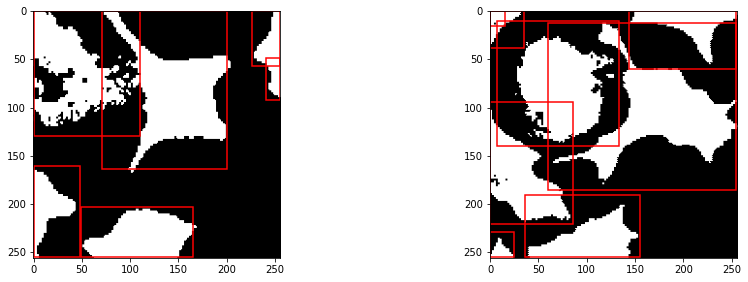

In [10]:
import torchvision
import matplotlib.pyplot as plt
from matplotlib import patches

images, labels = next(iter(train_loader))  # Batch of 5

def view(images, labels, n=2, std=1, mean=0):
    figure = plt.figure(figsize=(15,10))
    images = list(images)
    labels = list(labels)
    for i in range(n):
        out = torchvision.utils.make_grid(images[i])  
        ax = figure.add_subplot(2, 2, i + 1)
        ax.imshow(images[i].cpu().numpy().transpose((1,2,0)) * 255)
        l = labels[i]['boxes'].cpu().numpy()
        l[:,2] = l[:,2] - l[:,0]
        l[:,3] = l[:,3] - l[:,1]
        for j in range(len(l)):
            ax.add_patch(patches.Rectangle((l[j][0],l[j][1]),l[j][2],l[j][3],
                                           linewidth=1.5,
                                           edgecolor='r',
                                           facecolor='none')) 

view(images=images, labels=labels, n=2, std=1, mean=0)

In [11]:
epochs = 50
run = InitModel()

Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth


  0%|          | 0.00/170M [00:00<?, ?B/s]

In [12]:
run.main(train_loader, test_loader, epochs=epochs)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch: [0]  [ 0/12]  eta: 0:00:18  lr: 0.000184  loss: 4.2233 (4.2233)  loss_classifier: 0.9923 (0.9923)  loss_box_reg: 0.8609 (0.8609)  loss_mask: 1.4116 (1.4116)  loss_objectness: 0.8889 (0.8889)  loss_rpn_box_reg: 0.0695 (0.0695)  time: 1.5812  data: 0.0342  max mem: 4449
Epoch: [0]  [10/12]  eta: 0:00:02  lr: 0.002000  loss: 2.7607 (3.6730)  loss_classifier: 0.4124 (0.5562)  loss_box_reg: 0.5158 (0.6329)  loss_mask: 0.9018 (0.9541)  loss_objectness: 0.6359 (1.2921)  loss_rpn_box_reg: 0.2173 (0.2377)  time: 1.1436  data: 0.0298  max mem: 5246
Epoch: [0]  [11/12]  eta: 0:00:01  lr: 0.002000  loss: 2.5375 (3.4723)  loss_classifier: 0.4046 (0.5256)  loss_box_reg: 0.4700 (0.5921)  loss_mask: 0.8075 (0.9287)  loss_objectness: 0.5562 (1.1942)  loss_rpn_box_reg: 0.2132 (0.2318)  time: 1.1258  data: 0.0284  max mem: 5246
Epoch: [0] Total time: 0:00:13 (1.1263 s / it)
creating index...
index created!
Test:  [0/4]  eta: 0:00:04  model_time: 0.7201 (0.7201)  evaluator_time: 0.3410 (0.3410)  ti

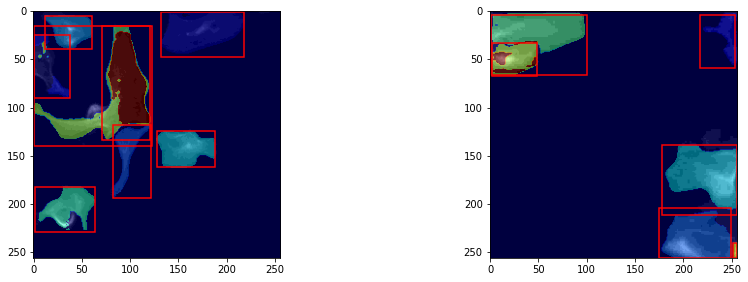

In [27]:
testone = ImageTest(w1[81:83])
testone.main(run.model, 0.80)

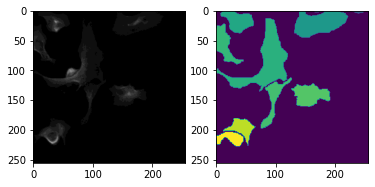

In [24]:
f, axarr = plt.subplots(1, 2)
axarr[0].imshow(w1[81] * 15, cmap='gray', vmin = 0, vmax = 255)
axarr[1].imshow(labels3d[81][:, :, 0])